In [85]:
import gym
import torch
import numpy as np

from gym.wrappers import GrayScaleObservation
from gym.wrappers import ResizeObservation
from gym.wrappers import FrameStack
from gym.wrappers import TransformObservation
import ale_py

import torch
from torch import nn
from torch.functional import F
import torch.optim as optim 

from matplotlib import pyplot as plt
from collections import deque
import sys
import importlib

from collections import deque
from dac_model import DACModel
from torch.distributions import Categorical


In [86]:
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
done = True
print('Press interrupt to stop execution')
rewards = 0.0
try:
    for step in range(5000):
        if done:
            state = env.reset()
            state, reward, interupted, terminated, info = env.step(env.action_space.sample())
            rewards += reward
            done = interupted or terminated
except KeyboardInterrupt:
    print('Execution Interrupted.')
finally:
    env.close()
print('Total Reward:', rewards)

Press interrupt to stop execution
Total Reward: 0.0


In [87]:

# Structure the environment for processing
env = GrayScaleObservation(env) # Converts the state to grayscale
env = TransformObservation(env, lambda x: x / 255.0)  # scale pixel values to range [0, 1]
env = ResizeObservation(env, 84) # Resizes the state into a 84x84.
env = FrameStack(env, 4) # Stacks 4 frames 



In [88]:
# Observation structure
obs, _ = env.reset()
obs = torch.Tensor(obs).squeeze()
print(obs.shape)

torch.Size([4, 84, 84])


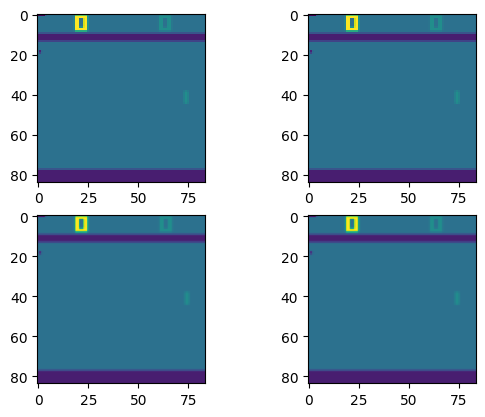

In [89]:
 # Plot the observation
fig, axs = plt.subplots(2, 2)
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(obs[idx])

In [90]:
num_episodes = 1000
batch_size = 32

In [91]:
# Define the DAC model
model = DACModel(num_channels=4, num_out=env.action_space.n)

# Set the number of episodes and maximum score
num_episodes = 10000
max_score = 21

# Define the discount factor
gamma = 0.99

# Define the optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the initial state
state = env.reset()

# Train the model
for episode in range(num_episodes):

    # Reset the environment and initialize the state
    state = env.reset()

    # Initialize the lists to store the trajectory
    states = []
    actions = []
    rewards = []

    # Play the game until the end of the episode
    done = False
    while not done:

        # Collect a trajectory of states, actions, and rewards using the current policy
        
        # action_probs = model.actor(torch.tensor(state).float().unsqueeze(0)).squeeze(0)
        # Collect a trajectory of states, actions, and rewards using the current policy
        # state_list = [state[i] for i in range(len(state))]
        # state = list(state) + [0]
        # state_tensor = torch.tensor([state], dtype=torch.float32)

        # state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        state_padded = state + [0]*(4-len(state))  # pad the state with zeros to make it of length 4
   
        state_tensor = torch.tensor(state_padded, dtype=torch.float32).unsqueeze(0)
        action_probs = model.actor(state_tensor).squeeze(0)
            
        # action_probs = model.actor(state_tensor).squeeze(0)
          
        action_dist = Categorical(action_probs)
        action = action_dist.sample().item()
        next_state, reward, done, info = env.step(action)

        # Store the trajectory
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        # Update the state
        state = next_state

    # Calculate the advantages and discounted rewards
    advantages = calculate_advantages(rewards, model.critic, gamma)
    discounted_rewards = calculate_discounted_rewards(rewards, gamma)

    # Convert the lists to tensors
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)
    advantages = torch.tensor(advantages)
    discounted_rewards = torch.tensor(discounted_rewards)

    # Calculate the actor and critic losses
    action_probs = model.actor(states)
    dist = Categorical(action_probs)
    log_probs = dist.log_prob(actions)
    actor_loss = -(log_probs * advantages).mean()
    critic_loss = F.mse_loss(model.critic(states).squeeze(), discounted_rewards)

    # Update the model parameters using backpropagation
    loss = actor_loss + critic_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the episode number and score
    score = sum(rewards)
    print(f"Episode: {episode}, Score: {score}")

    # Check if the game is solved
    if score >= max_score:
        print(f"Game solved in {episode} episodes!")
        break

# Evaluate model
evaluate_model(model)

TypeError: can only concatenate tuple (not "list") to tuple

In [ ]:
def evaluate_model(model):
    num_episodes = 10
    total_rewards = []
    for i in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = model.actor(state_tensor).squeeze(0)
            action = torch.argmax(action_probs).item()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    avg_reward = sum(total_rewards) / num_episodes
    print(f"Average reward per episode: {avg_reward}")


In [ ]:
def calculate_advantages(rewards, critic, gamma):
    """
    Calculates the advantages given the rewards and critic network.

    Args:
        rewards (list): The rewards for each time step in the trajectory.
        critic (nn.Module): The critic network.
        gamma (float): The discount factor.

    Returns:
        advantages (list): The advantages for each time step in the trajectory.
    """
    values = critic(torch.tensor(states, dtype=torch.float32))
    next_values = torch.cat((critic(torch.tensor(next_states, dtype=torch.float32)), torch.tensor([[0.0]])), dim=0)
    done_mask = torch.tensor(done, dtype=torch.float32)

    target = rewards + (1 - done_mask) * gamma * next_values[1:]
    td_error = target - values

    advantages = []
    advantage = 0.0
    for t in reversed(range(len(rewards))):
        advantage = td_error[t] + gamma * advantage * (1 - done_mask[t])
        advantages.insert(0, advantage)

    return advantages


def calculate_discounted_rewards(rewards, gamma):
    """
    Calculates the discounted rewards given the rewards and discount factor.

    Args:
        rewards (list): The rewards for each time step in the trajectory.
        gamma (float): The discount factor.

    Returns:
        discounted_rewards (list): The discounted rewards for each time step in the trajectory.
    """
    discounted_rewards = []
    reward_sum = 0.0
    for r in reversed(rewards):
        reward_sum = r + gamma * reward_sum
        discounted_rewards.insert(0, reward_sum)

    return discounted_rewards
